In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

In [11]:
model = TwoOsillators(
    strengthLambda=2, r0=1, typeA="distanceWgt", omega1=3, omega2=2, dt=0.01, couplesNum=1, 
    savePath="./data", overWrite=True, tqdm=True
)
model.run(40000)

  0%|          | 0/40000 [00:00<?, ?it/s]

(-5.0, 5.0)

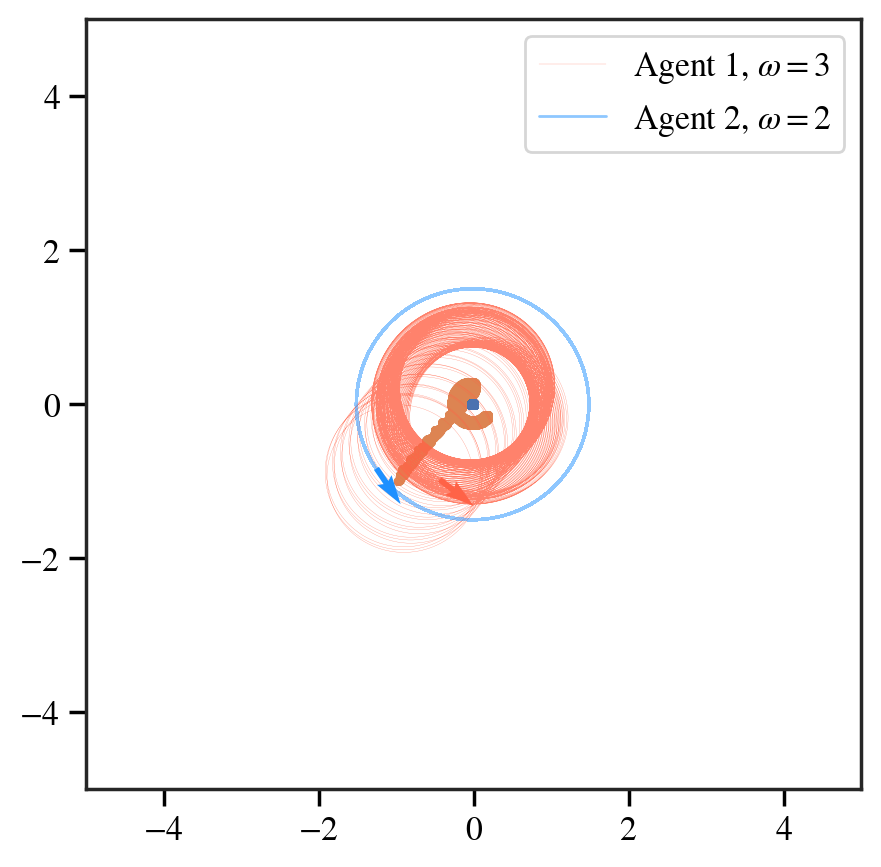

In [10]:
# model = models[1]
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2).transpose(0, 1, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta[0] = np.nan
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.8, lw=0.1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 * model.dt / totalPointTheta[:, 1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 * model.dt / totalPointTheta[:, 1] * np.cos(totalPhaseTheta[:, 1]), s=5, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 * model.dt / totalPointTheta[:, 0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 * model.dt / totalPointTheta[:, 0] * np.cos(totalPhaseTheta[:, 0]), s=5
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

bound = 5
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)

(-5.0, 5.0)

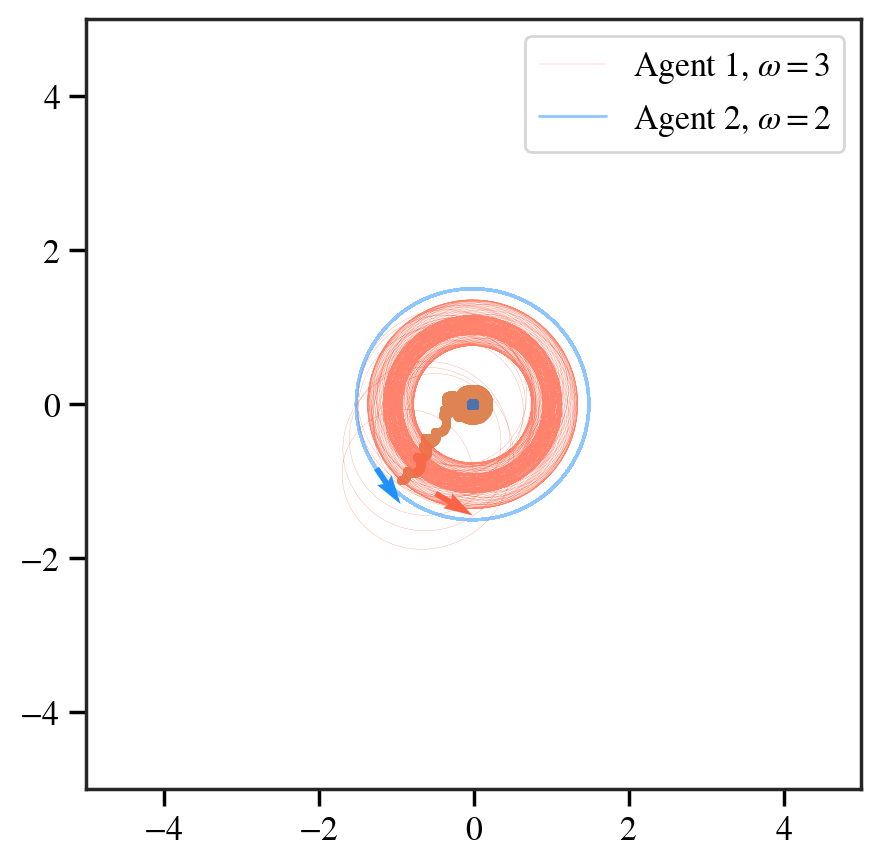

In [12]:
# model = models[1]
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2).transpose(0, 1, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta[0] = np.nan
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.8, lw=0.1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 * model.dt / totalPointTheta[:, 1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 * model.dt / totalPointTheta[:, 1] * np.cos(totalPhaseTheta[:, 1]), s=5, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 * model.dt / totalPointTheta[:, 0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 * model.dt / totalPointTheta[:, 0] * np.cos(totalPhaseTheta[:, 0]), s=5
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

bound = 5
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)

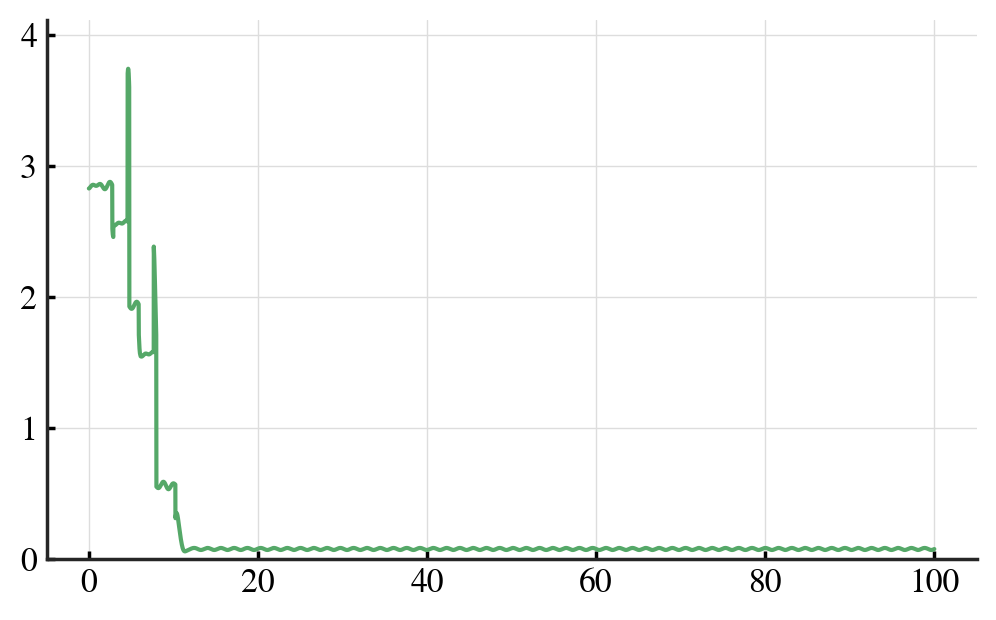

In [4]:
plt.subplots(1, 1, figsize=(6, 3.5))
colorIdx = 2

targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
tsCentersNoMod = get_ts_centers_no_mod(model)
sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
distance = np.sqrt(np.sum(sub ** 2, axis=1))
omega1, omega2 = model.omegaTheta
x = np.arange(len(distance)) * model.dt
plt.plot(x, distance, color=f"C{colorIdx}",
            label=fr"$d_0={model.r0}, \omega_1={omega1}, \omega_2={omega2}$")
# plt.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
#             color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1)
colorIdx += 1
plt.ylim(0, distance.max() * 1.1)

plt.tick_params(direction='in', length=3)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [19]:
from sympy import symbols, Eq, Function, sin, cos, diff, Matrix, sqrt, latex, simplify, sign, pi

# 定义符号变量
t = symbols('t')
f, v, r_1, omega_1, lamda, r_2, Delta_phi, omega_2, Delta_omega, Delta_theta = symbols('f v r_1 omega_1 lamda r_2 Delta_phi omega_2 Delta_omega Delta_theta')
r_1 = Function('r_1')(t)
Delta_phi = Function('Delta_phi')(t)
Delta_theta = Function('Delta_theta')(t)
f = Function('f')(r_1, r_2, Delta_phi)
alpha_2 = symbols("alpha_2")# -pi * sign(omega_2) / 2

# 定义未知函数
r_1_dot = r_1.diff(t)
Delta_phi_dot = Delta_phi.diff(t)
Delta_theta_dot = Delta_theta.diff(t)

# 定义方程组
eq1 = Eq(r_1_dot, v*cos(Delta_phi + Delta_theta + alpha_2))
eq2 = Eq(Delta_phi_dot, omega_2 - v/r_1*sin(Delta_phi + Delta_theta + alpha_2))
eq3 = Eq(Delta_theta_dot, Delta_omega - lamda*f*sin(Delta_theta))

# 打印方程组
print("动力学方程组:")
print(eq1)
print(eq2)
print(eq3)

动力学方程组:
Eq(Derivative(r_1(t), t), v*cos(alpha_2 + Delta_phi(t) + Delta_theta(t)))
Eq(Derivative(Delta_phi(t), t), omega_2 - v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t))
Eq(Derivative(Delta_theta(t), t), Delta_omega - lamda*f(r_1(t), r_2, Delta_phi(t))*sin(Delta_theta(t)))


In [20]:
M = Matrix([
    [diff(eq.rhs, var) for var in [r_1, Delta_phi, Delta_theta]]
    for eq in [eq1, eq2, eq3]
])
M

Matrix([
[                                                                          0,                                   -v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t)),         -v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t))],
[                   v*sin(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t)**2,                            -v*cos(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t),  -v*cos(alpha_2 + Delta_phi(t) + Delta_theta(t))/r_1(t)],
[-lamda*sin(Delta_theta(t))*Derivative(f(r_1(t), r_2, Delta_phi(t)), r_1(t)), -lamda*sin(Delta_theta(t))*Derivative(f(r_1(t), r_2, Delta_phi(t)), Delta_phi(t)), -lamda*f(r_1(t), r_2, Delta_phi(t))*cos(Delta_theta(t))]])

In [10]:
CDelta, r_0 = symbols(r'C_{\Delta} r_0')
f, g = symbols('f g')
# f = (1 + v * sqrt(2 - 2*cos(CDeltaPhi)) / abs(omega_2) / r_0) ** (-1 / r_0)
# g = -abs(omega_2) * (1 + v * sqrt(2 - 2*cos(CDeltaPhi)) / abs(omega_2) / r_0) ** (-1 / r_0 - 1) / v / sqrt(2 - 2*cos(CDeltaPhi)) / r_0**2

# -omega_2**2 / v * sign(omega_2) - lamda*v/omega_2*g*sin(CDeltaTheta)
# - lamda*v**2/omega_2*g*sin(CDeltaTheta)*sin(CDeltaPhi)
-lamda * f * cos(CDeltaTheta)

-f*lamda*cos(C_{\Delta\theta})

In [24]:
Mnew = Matrix([
    [0, -v * sign(omega_2), -v * sign(omega_2)],
    [-omega_2**2 / v * sign(omega_2), 0, 0],
    [-lamda*v/abs(omega_2)*g*sin(CDelta), lamda*v**2/omega_2**2*g*sin(CDelta)**2, -lamda * f * cos(CDelta)]
])
a, b, c, d, h = symbols('a b c d h')
# Mnew = Matrix([
#     [0, a, a],
#     [b, 0, 0],
#     [c, d, h]
# ])
Mnew

Matrix([
[                                      0,                           -v*sign(omega_2),                                    -v*sign(omega_2)],
[            -omega_2**2*sign(omega_2)/v,                                          0,                                                   0],
[-g*lamda*v*sin(C_{\Delta})/Abs(omega_2), g*lamda*v**2*sin(C_{\Delta})**2/omega_2**2, -lamda*f(r_1(t), r_2, Delta_phi(t))*cos(C_{\Delta})]])

In [25]:
# 求Mnew的行列式值
Mnew.det()

g*lamda*v**2*sin(C_{\Delta})**2*sign(omega_2)**2 + lamda*omega_2**2*f(r_1(t), r_2, Delta_phi(t))*cos(C_{\Delta})*sign(omega_2)**2

In [22]:
# 求解Mnew的特征值
eigs = Mnew.eigenvals()

In [121]:
v = 3
omega2 = 3
absDeltaOmega = 0.1
DeltaPhi = 1e-5

lamda = 0.5
r0 = 1
f = (1 + v * np.sqrt(2 - 2 * np.cos(DeltaPhi)) / np.abs(omega2) / r_0) ** (-1 / r0)
g = - np.abs(omega2) * f**(1 + r0) / (v * r0**2 * np.sqrt(2 - 2 * np.cos(DeltaPhi)))
m12 = v * np.sign(omega2)
m21 = - omega2**2 / v * np.sign(omega2)
m31 = - lamda * v / np.abs(omega2) * g * np.sin(DeltaPhi)
m32 = lamda * v**2 / omega2**2 * g * np.sin(DeltaPhi)**2
m33 = - lamda * f * np.cos(DeltaPhi)
matrix = np.array([
    [0, m12, m12],
    [m21, 0, 0],
    [m31, m32, m33]
])
eigenvalues = np.linalg.eigvals(matrix)
print(eigenvalues)

[ 0.04773832+2.74856413j  0.04773832-2.74856413j -0.59547165+0.j        ]


In [122]:
lamda * f, lamda, f

(0.49999500004979264, 0.5, 0.9999900000995853)

In [13]:
def get_2_maps(lamdaRange: np.ndarray, r0Range: np.ndarray, 
               v: float, omega2: float, absDeltaOmega: float, DeltaPhi: float):

    classMap = np.zeros((len(lamdaRange), len(r0Range)))
    fixPointMap = np.zeros((len(lamdaRange), len(r0Range)))

    for lamdaIdx, lamda in enumerate(lamdaRange):
        for r0Idx, r0 in enumerate(r0Range):
            f = (1 + v * np.sqrt(2 - 2 * np.cos(DeltaPhi)) / np.abs(omega2) / r0) ** (-1 / r0)
            g = - np.abs(omega2) * f**(1 + r0) / (v * r0**2 * np.sqrt(2 - 2 * np.cos(DeltaPhi)))
            m12 = v * np.sign(omega2)
            m21 = - omega2**2 / v * np.sign(omega2)
            m31 = - lamda * v / np.abs(omega2) * g * np.sin(DeltaPhi)
            m32 = lamda * v**2 / omega2**2 * g * np.sin(DeltaPhi)**2
            m33 = - lamda * f * np.cos(DeltaPhi)
            matrix = np.array([
                [0, m12, m12],
                [m21, 0, 0],
                [m31, m32, m33]
            ])
            eigenvalues = np.linalg.eigvals(matrix)
            if lamda * f < absDeltaOmega:  # escape
                fixPointMap[lamdaIdx, r0Idx] = 0
            else:
                fixPointMap[lamdaIdx, r0Idx] = 1
            if np.all(np.real(eigenvalues) < 0):  # stable
                if np.any(np.imag(eigenvalues) != 0):  # stable focus
                    classMap[lamdaIdx, r0Idx] = 1
                else:  # stable node
                    classMap[lamdaIdx, r0Idx] = 2
            elif np.all(np.real(eigenvalues) > 0):  # unstable
                if np.any(np.imag(eigenvalues) != 0):  # unstable focus
                    classMap[lamdaIdx, r0Idx] = 3
                else:  # unstable node
                    classMap[lamdaIdx, r0Idx] = 4
            else:  # saddle
                if np.sum(np.sign(np.real(eigenvalues)) == 1) == 2:
                    classMap[lamdaIdx, r0Idx] = 2.5
                else:
                    classMap[lamdaIdx, r0Idx] = 5

    return classMap, fixPointMap

v = 3
omega2 = 2
absDeltaOmega = 0.10
lamdaRange = np.linspace(0, 2, 100)
r0Range = np.linspace(0.01, 5, 100)
DeltaPhi = np.pi / 12  # np.pi / 12
classMap, fixPointMap = get_2_maps(lamdaRange, r0Range, v, omega2, absDeltaOmega, DeltaPhi)
maxLambdas = []
for r0Idx, r0 in enumerate(r0Range):
    maxLambda = np.max(lamdaRange[fixPointMap[:, r0Idx] == 0])
    maxLambdas.append(maxLambda)

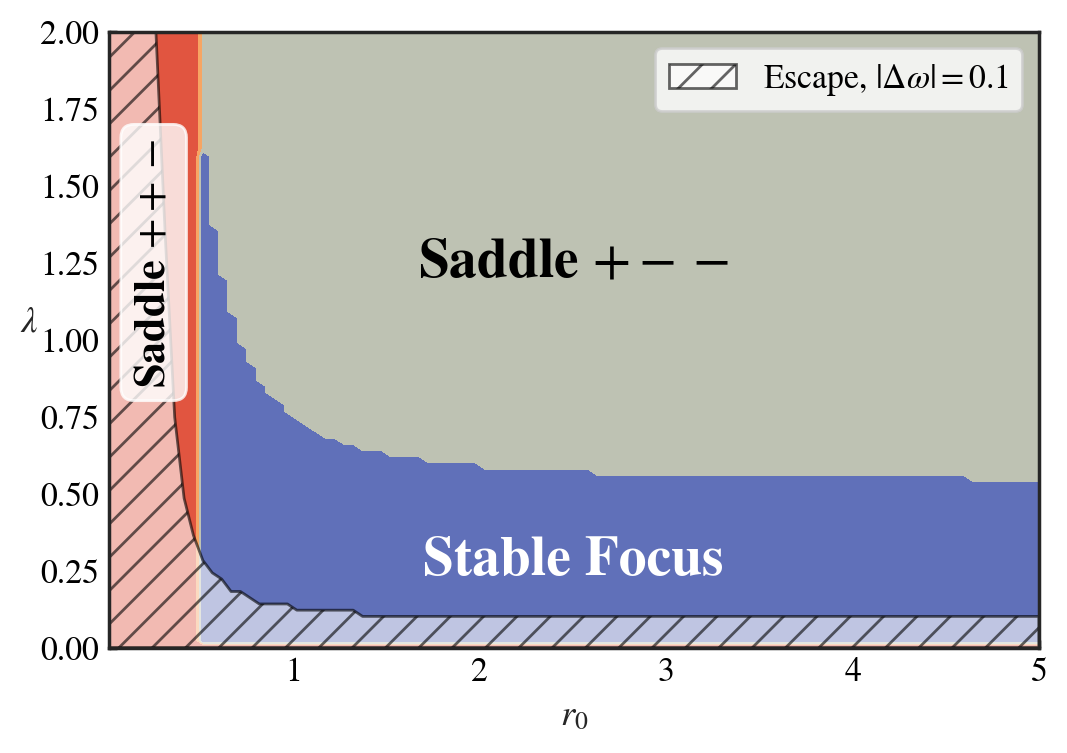

In [39]:
plt.figure(figsize=(6, 4))
plt.contourf(
    r0Range, lamdaRange, classMap, levels=len(np.unique(classMap)),
    cmap=cmap, alpha=1, 
)
plt.fill_between(r0Range, 0, maxLambdas, color="white", alpha=0.6, hatch="//", 
                 edgecolor="black", label=rf"Escape, $|\Delta\omega|={absDeltaOmega}$")
bbox_style = {
    'boxstyle': 'round',  # 文本框形状为圆角矩形
    'facecolor': 'white',  # 背景颜色为黄色
    'alpha': 0.8  # 透明度为0.5
}
plt.text(2.5, 0.28, "Stable Focus", color='white', fontsize=20, ha="center", va="center", fontweight="bold")
plt.text(2.5, 1.25, r"Saddle $+--$", color='black', fontsize=20, ha="center", va="center", fontweight="bold")
plt.text(0.25, 1.25, r"Saddle $++-$", color='black', fontsize=16, ha="center", va="center", fontweight="bold", 
         rotation=90, bbox=bbox_style)
# df = pd.DataFrame(classMap, index=lamdaRange, columns=r0Range)[::-1]
# df.index = np.round(df.index, 1)
# df.columns = np.round(df.columns, 2)
# sns.heatmap(df, xticklabels=10, yticklabels=10, cmap=cmap, cbar=False)
plt.xlabel(r"$r_0$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.tick_params(direction='in', length=3)
plt.legend()
plt.show()

In [454]:
absDeltaOmegaRange = np.linspace(0.1, np.pi, 20)

v = 3
omega2 = 2
DeltaPhi = np.pi / 12
lamdaRange = np.linspace(0, 2, 100)
r0Range = np.linspace(0.01, 5, 100)

totalPositionsFixPoint = []

for absDeltaOmega in absDeltaOmegaRange:
    classMap, fixPointMap = get_2_maps(lamdaRange, r0Range, v, omega2, absDeltaOmega, DeltaPhi)
    maxLambdas = []
    for r0Idx, r0 in enumerate(r0Range):
        maxLambda = np.max(lamdaRange[fixPointMap[:, r0Idx] == 0])
        maxLambdas.append(maxLambda)
    positions = np.array([maxLambdas, r0Range])
    positions = np.concatenate([positions, [np.ones(positions.shape[1]) * absDeltaOmega]]).T
    totalPositionsFixPoint.append(positions)

totalPositionsFixPoint = np.array(totalPositionsFixPoint)

totalPositionsClass = []
DeltaPhiRange = np.linspace(0.1, np.pi / 2, 20)

for DeltaPhi in DeltaPhiRange:
    classMap, fixPointMap = get_2_maps(lamdaRange, r0Range, v, omega2, absDeltaOmega, DeltaPhi)
    maxLambdas = []
    for r0Idx, r0 in enumerate(r0Range):
        saddleIdx = np.where(classMap[:, r0Idx] < 5)
        if len(saddleIdx[0]) == 0:
            maxLambda = 0
        else:
            maxLambda = np.max(saddleIdx)
        maxLambdas.append(maxLambda)
    positions = np.array([maxLambdas, r0Range])
    positions = np.concatenate([positions, [np.ones(positions.shape[1]) * DeltaPhi]]).T
    totalPositionsClass.append(positions)

totalPositionsClass = np.array(totalPositionsClass)

Text(0.5, 0, '$|\\Delta\\omega|$')

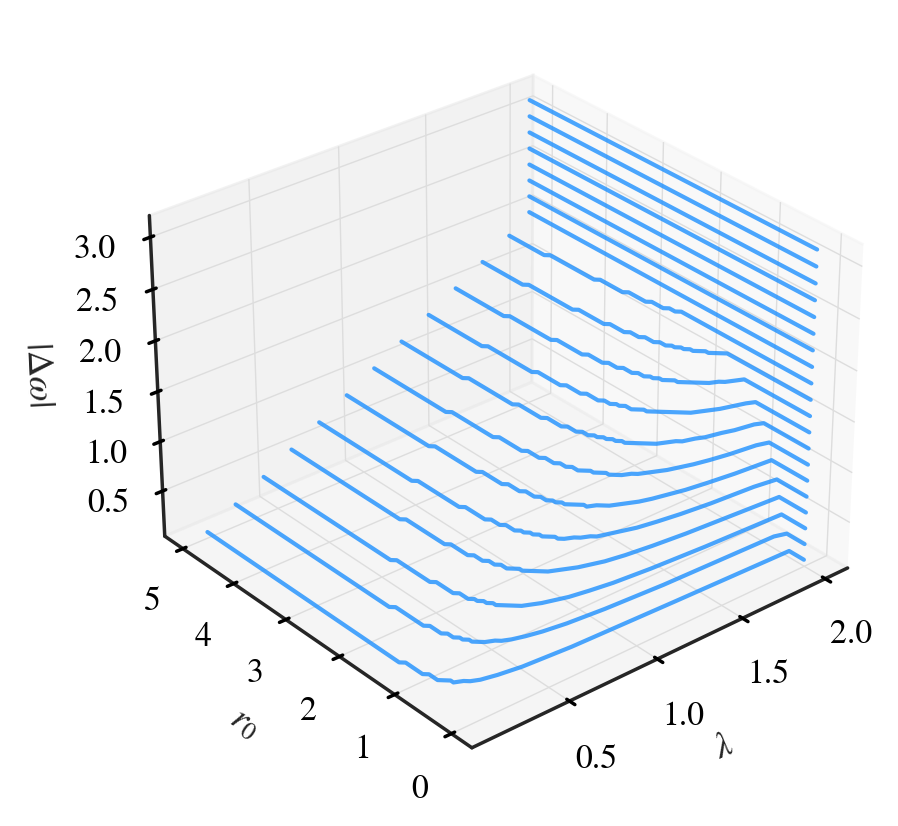

In [426]:
# 画3D图
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
concatPositions = np.concatenate(totalPositionsFixPoint)
# 转换为曲面要求的格式
x = lamdaRange
y = r0Range
z = np.zeros((len(x), len(y)))
# for l, r in product(lamdaRange, r0Range):
#     idxs = np.where(np.isclose(concatPositions[:, :2], [l, r]).all(axis=1))[0]
#     if len(idxs) > 0:
#         l, r, o = concatPositions[idxs[0]]
#         xIdx, yIdx = np.where(np.isclose(x, l))[0][0], np.where(np.isclose(y, r))[0][0]
#         z[xIdx, yIdx] = o

for positions in totalPositionsFixPoint:
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], color='dodgerblue', alpha=0.8)
    # ax.plot_surface
# ax.plot_surface(x, y, z, cmap=new_cmap, alpha=0.8)
# ax.plot_trisurf(concatPositions[:, 0], concatPositions[:, 1], concatPositions[:, 2], cmap=new_cmap, alpha=0.8)
ax.view_init(30, 230)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$r_0$")
ax.set_zlabel(r"$|\Delta\omega|$")

Text(0.5, 0, '$\\Delta\\varphi$')

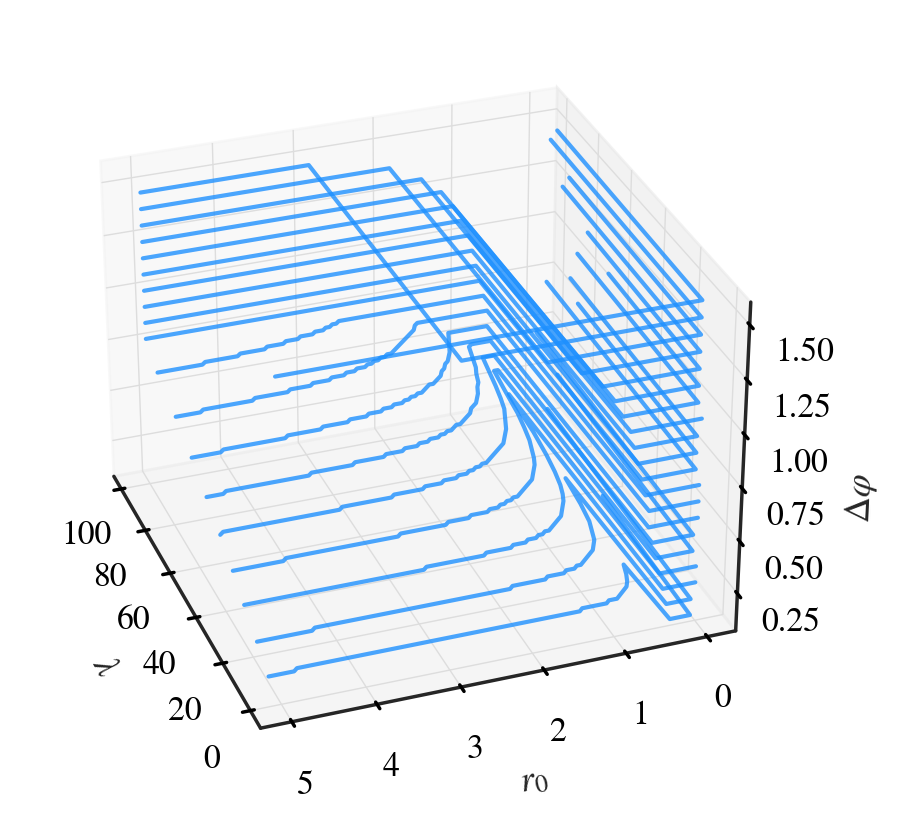

In [480]:
# 画3D图
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
concatPositions = np.concatenate(totalPositionsClass)
# 转换为曲面要求的格式
x = lamdaRange
y = r0Range
z = np.zeros((len(x), len(y)))
# for l, r in product(lamdaRange, r0Range):
#     idxs = np.where(np.isclose(concatPositions[:, :2], [l, r]).all(axis=1))[0]
#     if len(idxs) > 0:
#         l, r, o = concatPositions[idxs[0]]
#         xIdx, yIdx = np.where(np.isclose(x, l))[0][0], np.where(np.isclose(y, r))[0][0]
#         z[xIdx, yIdx] = o

for positions in totalPositionsClass:
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], color='dodgerblue', alpha=0.8)
    # break
    # ax.plot_surface
# ax.plot_surface(x, y, z, cmap=new_cmap, alpha=0.8)
# ax.plot_trisurf(concatPositions[:, 0], concatPositions[:, 1], concatPositions[:, 2], cmap=new_cmap, alpha=0.8)
ax.view_init(30, 160)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$r_0$")
ax.set_zlabel(r"$\Delta\varphi$")